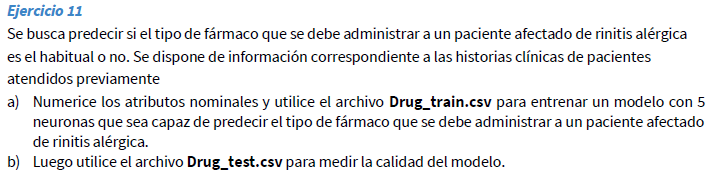

In [2]:
# configuración para notebook con instalación LOCAL
FUENTES_DIR  = '../../Datos-Fuentes/Fuentes/'     # carpeta donde se encuentran archivos .py auxiliares
DATOS_DIR    = '../../Datos-Fuentes/Datos/'      # carpeta donde se encuentran los datasets
MODELOS_DIR  = '../Modelos/'    # carpeta donde se encuentran los modelos
ARCHIVOs_DIR = '../Archivos/'   # carpeta recuperar o copiar archivos

# agrega ruta de busqueda donde tenemos archivos .py
import sys
sys.path.append(FUENTES_DIR)

In [32]:
import pandas as pd      # para trabajar con archivos de datos csv, excel, etc: https://pandas.pydata.org/docs/getting_started/tutorials.html
import chardet           # para detectar la codificación de texto en archivos

nombre_archivo = DATOS_DIR + 'Drug5.csv' # archivo de hojas

#-- detectando la codificación de caracteres usada ----
with open(nombre_archivo, 'rb') as f:
    result = chardet.detect(f.read())  # or readline if the file is large

# recupera el archivo en un objeto dataframe de pandas utilizando la codificación detectada
df = pd.read_csv(nombre_archivo, encoding=result['encoding'])

display(df)

,Age,Sex,BP,Cholesterol,Na,K,Drug
0,23,F,HIGH,HIGH,0.792535,0.031258,drugY
1,47,M,LOW,HIGH,0.739309,0.056468,drugC
2,47,M,LOW,HIGH,0.697269,0.068944,drugC
3,28,F,NORMAL,HIGH,0.563682,0.072289,drugX
4,61,F,LOW,HIGH,0.559294,0.030998,drugY
...,...,...,...,...,...,...,...
195,56,F,LOW,HIGH,0.848774,0.073380,drugC
196,16,M,LOW,HIGH,0.743021,0.061886,drugC
197,52,M,NORMAL,HIGH,0.549945,0.055581,drugX
198,23,M,NORMAL,NORMAL,0.784520,0.055959,drugX


In [33]:
df.isnull().sum()

Age            0
Sex            0
BP             0
Cholesterol    0
Na             0
K              0
Drug           0
dtype: int64

## Numeriso los atributos nominales

In [34]:
from sklearn.preprocessing import LabelEncoder, OrdinalEncoder
label_encoder = LabelEncoder()

df['Sex'] = label_encoder.fit_transform(df['Sex'])
df

,Age,Sex,BP,Cholesterol,Na,K,Drug
0,23,0,HIGH,HIGH,0.792535,0.031258,drugY
1,47,1,LOW,HIGH,0.739309,0.056468,drugC
2,47,1,LOW,HIGH,0.697269,0.068944,drugC
3,28,0,NORMAL,HIGH,0.563682,0.072289,drugX
4,61,0,LOW,HIGH,0.559294,0.030998,drugY
...,...,...,...,...,...,...,...
195,56,0,LOW,HIGH,0.848774,0.073380,drugC
196,16,1,LOW,HIGH,0.743021,0.061886,drugC
197,52,1,NORMAL,HIGH,0.549945,0.055581,drugX
198,23,1,NORMAL,NORMAL,0.784520,0.055959,drugX


## Mapeo 

In [35]:
mapeo = {
    'BP': {'LOW':0.0, 'NORMAL':0.5, 'HIGH':1.0},
    'Cholesterol': {'NORMAL':0.5, 'HIGH':1.0},
}

df.replace(mapeo, inplace=True)
display(df)

C:\Users\Peter\AppData\Local\Temp\ipykernel_28552\1878020065.py:6: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df.replace(mapeo, inplace=True)


,Age,Sex,BP,Cholesterol,Na,K,Drug
0,23,0,1.0,1.0,0.792535,0.031258,drugY
1,47,1,0.0,1.0,0.739309,0.056468,drugC
2,47,1,0.0,1.0,0.697269,0.068944,drugC
3,28,0,0.5,1.0,0.563682,0.072289,drugX
4,61,0,0.0,1.0,0.559294,0.030998,drugY
...,...,...,...,...,...,...,...
195,56,0,0.0,1.0,0.848774,0.073380,drugC
196,16,1,0.0,1.0,0.743021,0.061886,drugC
197,52,1,0.5,1.0,0.549945,0.055581,drugX
198,23,1,0.5,0.5,0.784520,0.055959,drugX


# **PREGUNTA**
**Es lo mismo como numeriso o mapeo?????**

## Selecciono los atributos y normalizacion

In [38]:
from sklearn import preprocessing
import numpy as np

# %% separa atributos para entrenar de clases
X_raw = np.array(df.iloc[:,:-1])  # recupera todas las columnas salvo la primera (es la clase)
T_raw = np.array(df.iloc[:,-1])    # recupera solo la primera columna (es la clase)

clases = np.unique(T_raw)  # obtiene las clases sin repeticiones
print('Las clases del dataset son :', clases)

# Normalizacion con media y desviacion
scaler = preprocessing.StandardScaler()
X = scaler.fit_transform(X_raw)

T_raw = T_raw.reshape((-1,1))   # fuerza formato (N,1) sino es (N,)

# los target deben tener formato one hot.
# clase 1 => 100 | clase 2 => 010 | clase 3 => 001
encoder = preprocessing.OneHotEncoder(handle_unknown='ignore')
T = encoder.fit_transform(T_raw.reshape(-1,1)).toarray()

Las clases del dataset son : ['drugA' 'drugB' 'drugC' 'drugX' 'drugY']


## Entrenamiento de neurona multiclase 

In [53]:
from ClassRNMulticlase import RNMulticlase
from sklearn import model_selection

###############################################################################
# neurona multiclase con sigmoid y ECM
ERROR = 1e-03
ALFA = 0.2
#FUN = 'sigmoid'
#FUN = 'tanh'
FUN = 'softmax'
MAX_ITE = 400
CORRIDAS = 30
TEST_SIZE = .2
#COSTO = 'ECM'
COSTO = 'EC'

print('\nNeurona con %s' %FUN)

prom_ite = 0
prom_acc_train = 0
prom_acc_test = 0
veces_train = 0
veces_test = 0

for nro_ite in range(CORRIDAS):
    # Establece resultado esperado según la clase. 1=clase esperada, 0=otra clase

    if FUN == 'tanh':
        T_new = 2*T-1
        pass
    else:
        T_new = T

    X_train, X_test, Y_train, Y_test = model_selection.train_test_split(X, T_new, test_size=TEST_SIZE)#, random_state=42)

    # Entrena perceptrón
    modelo = RNMulticlase(alpha=ALFA, n_iter=MAX_ITE, FUN=FUN, COSTO=COSTO, cotaE=ERROR)
    modelo.fit(X_train, Y_train)

    (W, b, iteraciones) = (modelo.w_, modelo.b_, len(modelo.errors_))

    prom_ite = prom_ite + iteraciones

    # efectividad entrenamiento
    efectividad = 100*modelo.accuracy(X_train, Y_train)

    prom_acc_train = prom_acc_train + efectividad
    if (100-efectividad<0.0000001):
      veces_train = veces_train + 1
    print("E %6.2f%% de efectividad con %d iteraciones" % (efectividad, iteraciones ))
    # efectividad testeo
    efectividad = 100*modelo.accuracy(X_test, Y_test)

    prom_acc_test = prom_acc_test + efectividad
    if (100-efectividad<0.0000001):
      veces_test = veces_test + 1

    print("T %6.2f%% de efectividad con %d iteraciones" % (efectividad, iteraciones ))

print('promedio iteraciones  : %6.2f' % (prom_ite/CORRIDAS))
print('promedio acc. train   : %6.2f' % (prom_acc_train/CORRIDAS))
print('promedio acc. test    : %6.2f' % (prom_acc_test/CORRIDAS))
print('ejec. train con 100%%  : %3d' % (veces_train))
print('ejec.  test con 100%%  : %3d' % (veces_test))


Neurona con softmax
E  99.38% de efectividad con 47 iteraciones
T  97.50% de efectividad con 47 iteraciones
E 100.00% de efectividad con 46 iteraciones
T  95.00% de efectividad con 46 iteraciones
E  99.38% de efectividad con 48 iteraciones
T  97.50% de efectividad con 48 iteraciones
E 100.00% de efectividad con 45 iteraciones
T  92.50% de efectividad con 45 iteraciones
E  99.38% de efectividad con 48 iteraciones
T 100.00% de efectividad con 48 iteraciones
E 100.00% de efectividad con 42 iteraciones
T  95.00% de efectividad con 42 iteraciones
E  98.75% de efectividad con 46 iteraciones
T  92.50% de efectividad con 46 iteraciones
E 100.00% de efectividad con 48 iteraciones
T  97.50% de efectividad con 48 iteraciones
E  99.38% de efectividad con 48 iteraciones
T 100.00% de efectividad con 48 iteraciones
E  99.38% de efectividad con 45 iteraciones
T  95.00% de efectividad con 45 iteraciones
E  98.75% de efectividad con 46 iteraciones
T  95.00% de efectividad con 46 iteraciones
E  99.38% d